# ANALYSIS OF REAL DATA (SRON)

From real MnKa1, MnKa2, MnKb it creates a library of optimal filters and reconstruct (and calibrate) data calculating FWHM of lines

0. Imports and definitions

1. Creation of Kas library

        1.1. Transform h5 files to FITS (using PHASE info) 
        1.2. Populate PH_ID column with row (record) number
        1.3. Select records with Ka1 and Ka2 lines (by limiting the Pulse height)
        1.4. Create a library with this new file with Kas lines

2. Creation of Ka2 library

    2.1 Reconstruct Kas data with initial library
    
    2.2 Select only Ka2 pulses not in multiple-pulse records (from R script)
    
        2.2.0 Find/identify multiple-pulse records
        2.2.1 Read data from HR Kas evt file to identify Ka1 and Ka2
        2.2.2 Fit a double Gaussian to select Ka2 pulses
        2.2.3 Select PH_ID of (non)Ka2 pulses
        2.2.4 Extract Ka2 pulses to build the new library
        
    2.3 Build the new library of Ka2 pulses
 
3. Reconstruct all pulses with new Ka2 library

4. Calibrate data fitting 2 Gaussians (Kas) + 1 Gaussian (Kb)

        4.1 Read HR pulses
        4.2 Fit 2 gaussians to Kas and 1 gaussian to Kb
        4.3 Create gain scale
        4.4 Calibrate energies
        
        
5. Get FWHM of Kas lines fitting Voigt profiles

6. Jitter correction

    6.1 Plot recon PH vs PHASE (PHI+LAGS) & Fit a polynomial
    
    6.2 Fit gaussians, create new Gain scale and re-calibrate energies
    
    6.3 Fit histogram of jitter-corrected energies
    
7. baseline drift correction

    7.1 Plot jiterr_recon PH vs Baseline & Fit polynomial
    
    7.2 Fit gaussians, create new Gain scale and re-calibrate energies
    
    7.3 Fit histogram of baseline-jitter-corrected energies
        

## 0) Imports and definitions

In [1]:
from subprocess import check_call, check_output,STDOUT
from astropy.io import fits
from scipy.stats import norm
from scipy.optimize import curve_fit
from statistics import mean
import math
import sys, os
import shutil, tempfile, shlex
import numpy as np
import numpy.polynomial.polynomial as poly
import auxpy
import matplotlib.pyplot as plt
from datetime import datetime
import pandas
from astropy.modeling import models, fitting
from lmfit import minimize, Parameters
from scipy.stats import norm, cauchy
#from numina.array.stats import summary

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"

In [2]:
# data files
fileNum = "2"
noiseNum = "2"
resDir = "file" + str(fileNum) + "noise" + str(noiseNum)
if not os.path.exists(resDir):
    os.makedirs(resDir)
ratio = 5 # ratio Ka2_gaussProb/Ka1_gaussProb
file0ph = "file" + fileNum + "ph.fits"   # initial file with all records
fileph  = "file" + fileNum + "ph_phid.fits" # initial file with all records and PH_ID column populated
fileph_Kas = "file" + fileNum + "ph_phid_Kas.fits" # data file with only those records with Kas lines
noisefile = "noise" + noiseNum + "ph_8192_noisespec.fits"

In [3]:
PHmin = 159000 # ADC units to limit Kas lines
PHmax = 161000 
# Calibration lines CALDB20161122

class RxLines(object):
    def __init__(self, label, energy_eV, fwhm_eV, rel_amplitude):
        self.label = label
        self.energy_eV = energy_eV
        self.fwhm_eV = fwhm_eV
        self.rel_amplitude = rel_amplitude
    
MnKas_list = list()
MnKas_list.append(RxLines(label='Ka1', energy_eV=5898.882, fwhm_eV=1.7145, rel_amplitude=0.784))
MnKas_list.append(RxLines(label='Ka2', energy_eV=5897.898, fwhm_eV=2.0442, rel_amplitude=0.263))
MnKas_list.append(RxLines(label='Ka3', energy_eV=5894.864, fwhm_eV=4.4985, rel_amplitude=0.067))
MnKas_list.append(RxLines(label='Ka4', energy_eV=5896.566, fwhm_eV=2.6616, rel_amplitude=0.095))
MnKas_list.append(RxLines(label='Ka5', energy_eV=5899.444, fwhm_eV=0.97669, rel_amplitude=0.071))
MnKas_list.append(RxLines(label='Ka6', energy_eV=5902.712, fwhm_eV=1.5528, rel_amplitude=0.011))
MnKas_list.append(RxLines(label='Ka7', energy_eV=5887.772, fwhm_eV=2.3604, rel_amplitude=0.369))
MnKas_list.append(RxLines(label='Ka8', energy_eV=5886.528, fwhm_eV=4.2168, rel_amplitude=0.1))
MnKas_cmass = 5894.40 # eV
Ka1eV = 5.88765 # eV 
Ka2eV = 5.89875 # eV for lib creation

MnKb_list = list()
MnKb_list.append(RxLines(label='Kb1', energy_eV=6490.89, fwhm_eV=1.83, rel_amplitude=0.608))
MnKb_list.append(RxLines(label='Kb2', energy_eV=6486.31, fwhm_eV=9.4, rel_amplitude=0.109))
MnKb_list.append(RxLines(label='Kb3', energy_eV=6477.73, fwhm_eV=13.22, rel_amplitude=0.077))
MnKb_list.append(RxLines(label='Kb4', energy_eV=6490.06, fwhm_eV=1.81, rel_amplitude=0.397))
MnKb_list.append(RxLines(label='Kb5', energy_eV=6488.83, fwhm_eV=2.81, rel_amplitude=0.176))
MnKb_cmass = 6486.38 # eV

In [4]:
# library Kas creation
plen = 8192
oflen = 8192
preBuffer = 0
method = "OPTFILT"
F0orB0 = "F0"
nS = 5
sU = 3
sD = 4
libKas = resDir + "/" + "library_Kas_" + str(plen) + ".fits"

In [5]:
# reconstructed files
evtKas_libKas = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKas_" + method + str(oflen) + ".fits"
evtKas_libKas_HR = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKas_" + method + str(oflen) + "_HR.fits"
evtKas_libKa2 = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + ".fits"
evtKas_libKa2_HR = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + "_HR.fits"
evt_libKa2 = resDir + "/" + "evt_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + ".fits"
evt_libKa2_HR = resDir + "/" + "evt_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + "_HR.fits"
evt_libKa2_abs = resDir + "/" + "evtabs_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + ".fits"
evt_libKa2_abs_HR = resDir + "/" + "evtabs_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + "_HR.fits"

In [6]:
# library Ka2 creation
fileph_Ka2 = resDir + "/" + "file_Ka2.fits" # data file with only those single records with Ka2 lines
libKa2 = resDir + "/" + "library_Ka2_ratio" + str(ratio) + "_" + str(plen) + ".fits"

## Auxiliary functions

In [7]:
# EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTION
# also: from statsmodels.distributions.empirical_distribution import ECDF
def ecdf(data):
    """Compute the Empirical Cumulative Distribution Function"""
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n + 1) / n
    return x, y

In [58]:
# Residuals of 2 GAUSS CDF model wrt the data
def residual_2gauss(params, x, cdf_data):
    w1 = params['w1'].value   # relative weight of 1st gauss
    w2 = params['w2'].value   # relative weight of 2nd gauss
    mu1 = params['mu1'].value
    mu2 = params['mu2'].value
    sigma1 = params['sigma1'].value
    sigma2 = params['sigma2'].value
    
    model1 = norm.cdf(x, loc=mu1, scale=sigma1)
    model2 = norm.cdf(x, loc=mu2, scale=sigma2)
    model = model1 * w1 + model2 * w2
    
    return model - cdf_data

In [9]:
# Residuals of 2 LORENTZIAN (CAUCHY) CDF model wrt the data
def residual_2lorentz(params, x, cdf_data):
    ndat = len(x)
    w1 = params['n1'].value / ndat
    w2 = 1 - w1
    mu1 = params['mu1'].value
    sigma1 = params['sigma1'].value
    mu2 = params['mu2'].value
    sigma2 = params['sigma2'].value
    
    model1 = cauchy.cdf(x, loc=mu1, scale=sigma1)
    model2 = cauchy.cdf(x, loc=mu2, scale=sigma2)
    model = model1 * w1 + model2 * w2
    
    return model - cdf_data

In [10]:
# Residuals of 2 Voigt CDF model wrt the data
def residual_2voigt(params, x, cdf_data):
    w1a = params['w1a'].value
    w1b = params['w1b'].value
    w2a = params['w2a'].value
    w2b = params['w2b'].value
    mu1 = params['mu1'].value
    mu2 = params['mu2'].value
    sigmag = params['sigmag'].value
    sigmal = params['sigmal'].value

    model1a = norm.cdf(x, loc=mu1, scale=sigmag)
    model2a = norm.cdf(x, loc=mu2, scale=sigmag)
    model1b = cauchy.cdf(x, loc=mu1, scale=sigmal)
    model2b = cauchy.cdf(x, loc=mu2, scale=sigmal)
    model = model1a * w1a + model1b * w1b + model2a * w2a + model2b * w2b
    
    return model - cdf_data

In [51]:
def plot_hist_2gauss(data, params, xlabel='x', labelprefix=''):

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
    values, bins, patches = ax.hist(data, bins=100, density=True, alpha=0.5)
    rug(ax,data)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('probability density')

    w1 = params['w1'].value
    w2 = params['w2'].value
    xmin = min(data)
    xmax = max(data)
    xplot = np.linspace(start=min(data), stop=max(data), num=100)
    yplot1 = norm.pdf(xplot, loc=params['mu1'].value, scale=params['sigma1'].value) * w1
    yplot2 = norm.pdf(xplot, loc=params['mu2'].value, scale=params['sigma2'].value) * w2
    yplot = yplot1 + yplot2
    ax.plot(xplot, yplot1, label=labelprefix + ' fun1')
    ax.plot(xplot, yplot2, label=labelprefix + ' fun2')
    ax.plot(xplot, yplot, label=labelprefix + ' fun1+fun2')
    ax.legend()

In [12]:
def plot_hist_2lorentz(data, params, xlabel='x', labelprefix=''):
    ndat = len(data)

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
    values, bins, patches = ax.hist(data, bins=100, density=True)
    ax.plot(data, [0]*ndat, '|', color='k', markersize=30, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('probability density')

    w1 = params['n1'].value / ndat
    w2 = 1 - w1
    xmin = min(data)
    xmax = max(data)
    xplot = np.linspace(start=min(data), stop=max(data), num=100)
    yplot1 = cauchy.pdf(xplot, loc=params['mu1'].value, scale=params['sigma1'].value) * w1
    yplot2 = cauchy.pdf(xplot, loc=params['mu2'].value, scale=params['sigma2'].value) * w2
    yplot = yplot1 + yplot2
    ax.plot(xplot, yplot1, label=labelprefix + ' fun1')
    ax.plot(xplot, yplot2, label=labelprefix + ' fun2')
    ax.plot(xplot, yplot, label=labelprefix + ' fun1+fun2')
    ax.legend()

In [13]:
def plot_hist_2voigt(data, params, xlabel='x', labelprefix=''):
    ndat = len(data)

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
    values, bins, patches = ax.hist(data, bins=100, density=True)
    ax.plot(data, [0]*ndat, '|', color='k', markersize=30, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('probability density')

    w1a = params['w1a'].value
    w1b = params['w1b'].value
    w2a = params['w2a'].value
    w2b = params['w2b'].value
    xmin = min(data)
    xmax = max(data)
    xplot = np.linspace(start=min(data), stop=max(data), num=100)
    yplot1a = norm.pdf(xplot, loc=params['mu1'].value, scale=params['sigmag'].value) * w1a
    yplot2a = norm.pdf(xplot, loc=params['mu2'].value, scale=params['sigmag'].value) * w2a
    yplot1b = cauchy.pdf(xplot, loc=params['mu1'].value, scale=params['sigmal'].value) * w1b
    yplot2b = cauchy.pdf(xplot, loc=params['mu2'].value, scale=params['sigmal'].value) * w2b
    yplot = yplot1a + yplot1b + yplot2a + yplot2b
    ax.plot(xplot, yplot1a, label=labelprefix + ' fun1a')
    ax.plot(xplot, yplot1b, label=labelprefix + ' fun1b')
    ax.plot(xplot, yplot2a, label=labelprefix + ' fun2a')
    ax.plot(xplot, yplot2b, label=labelprefix + ' fun2b')
    ax.plot(xplot, yplot, label=labelprefix + ' fun1ab+fun2ab')
    ax.legend()

In [56]:
def ecdf_2gauss(data, params, modellabel='model', plot=True):
    # compute ECDF of data
    xecdf_data, yecdf_data = ecdf(data=data)
    
    # compute CDF of model
    ycdf_model1 = norm.cdf(xecdf_data, loc=params['mu1'].value, scale=params['sigma1'].value)
    ycdf_model2 = norm.cdf(xecdf_data, loc=params['mu2'].value, scale=params['sigma2'].value)
    w1 = params['w1'].value
    w2 = params['w2'].value
    ycdf_model = ycdf_model1 * w1 + ycdf_model2 * w2
    
    if plot:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
        ax.scatter(xecdf_data, yecdf_data, label='data')
        ax.scatter(xecdf_data, ycdf_model, label=modellabel)
        ax.legend()
    
    return xecdf_data, yecdf_data, ycdf_model

In [15]:
def ecdf_2lorentz(data, params, modellabel='model', plot=True):
    # compute ECDF of data
    ndat = len(data)
    xecdf_data, yecdf_data = ecdf(data=data)
    
    # compute CDF of model
    ycdf_model1 = cauchy.cdf(xecdf_data, loc=params['mu1'].value, scale=params['sigma1'].value)
    ycdf_model2 = cauchy.cdf(xecdf_data, loc=params['mu2'].value, scale=params['sigma2'].value)
    w1 = params['n1'].value / ndat
    w2 = 1 - w1
    ycdf_model = ycdf_model1 * w1 + ycdf_model2 * w2
    
    if plot:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
        ax.scatter(xecdf_data, yecdf_data, label='data')
        ax.scatter(xecdf_data, ycdf_model, label=modellabel)
        ax.legend()
    
    return xecdf_data, yecdf_data, ycdf_model

In [16]:
def ecdf_2voigt(data, params, modellabel='model', plot=True):
    # compute ECDF of data
    xecdf_data, yecdf_data = ecdf(data=data)
    
    # compute CDF of model
    ycdf_model1a = norm.cdf(xecdf_data, loc=params['mu1'].value, scale=params['sigmag'].value)
    ycdf_model2a = norm.cdf(xecdf_data, loc=params['mu2'].value, scale=params['sigmag'].value)
    ycdf_model1b = cauchy.cdf(xecdf_data, loc=params['mu1'].value, scale=params['sigmal'].value)
    ycdf_model2b = cauchy.cdf(xecdf_data, loc=params['mu2'].value, scale=params['sigmal'].value)
    w1a = params['w1a'].value
    w1b = params['w1b'].value
    w2a = params['w2a'].value
    w2b = params['w2b'].value
    ycdf_model = ycdf_model1a * w1a + ycdf_model1b * w1b + \
                 ycdf_model2a * w2a + ycdf_model2b * w2b
    
    if plot:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
        ax.scatter(xecdf_data, yecdf_data, label='data')
        ax.scatter(xecdf_data, ycdf_model, label=modellabel)
        ax.legend()
    
    return xecdf_data, yecdf_data, ycdf_model

In [17]:
def fit2GaussAndRatio(data=None, a1=50, a2=90, mean1=5.8, mean2=5.9, sig1=0.005, sig2=0.005, nbins1=200, xlab=None):

    """"
    
    Fit 2 Gaussians (Ka1, Ka2) to Kas histogram 
    Histograms are created and plotted with matplotlib.pyplot.hist in Density
    Gaussians functions from astropy.fitting module (fitting by LevMarLSQFitter)
    
    data1: (array) data for 1st histogram
    a1: (float) initial amplitude for Gaussian1
    a2: (float)initial amplitude for Gaussian2
    mean1: (float)initial mean for Gaussian1
    mean2: (float)initial mean for Gaussian2
    sig1: (float)std dev for Gaussian1
    sig2: (float)std dev for Gaussian2
    nbins1: number of bins for first (Kas) histogram
    
    """
    fig = plt.figure(figsize=(16,6))
    ax1 = fig.add_subplot(1, 2, 1)

    # create histogram
    bin_heights, bin_borders, _ = ax1.hist(data, bins=nbins1, density=True,label="Histogram", alpha=0.5)
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    # fit two gaussians to density-histogram (also "curve_fit" ?)
    gg_init = (models.Gaussian1D(amplitude=a1, mean=mean1, stddev=sig1) +
               models.Gaussian1D(amplitude=a2, mean=mean2, stddev=sig2))
    #fitter = fitting.SLSQPLSQFitter()
    fitter = fitting.LevMarLSQFitter()
    gg_fit = fitter(gg_init, bin_centers, bin_heights)
    print("Message (Kas)=", fitter.fit_info['message'])

    #C1 = gg_fit.param_sets[0][0]
    #mean1 = gg_fit.param_sets[1][0] #u.a.
    #sigma1 = gg_fit.param_sets[2][0] #u.a.
    #C2 = gg_fit.param_sets[3][0] 
    #mean2 = gg_fit.param_sets[4][0] #u.a.
    #sigma2 = gg_fit.param_sets[5][0] #u.a.

    C1 = gg_fit.amplitude_0[0]
    mean1 = gg_fit.mean_0[0]
    sigma1 = gg_fit.stddev_0[0]
    fwhm1 = sigma1 *1000.* 2*np.sqrt(2*np.log(2)) #mu.a.
    C2 = gg_fit.amplitude_1[0]
    mean2 = gg_fit.mean_1[0]
    sigma2 = gg_fit.stddev_1[0]
    fwhm2 = sigma2 * 1000. * 2*np.sqrt(2*np.log(2)) #mu.a.
    #gg_fit.fit_info['residuals']
    g1 = models.Gaussian1D(amplitude=C1, mean=mean1, stddev=sigma1)
    g2 = models.Gaussian1D(amplitude=C2, mean=mean2, stddev=sigma2)
    ratioGG = g2(x_interval_for_fit)/g1(x_interval_for_fit)
    #print("minGG=",min(ratioGG), "maxGG=",max(ratioGG))

    # plot histogram and Gaussians fit
    ax1.plot(x_interval_for_fit, gg_fit(x_interval_for_fit), label='Gauss fit')
    ax1.plot(x_interval_for_fit, g1(x_interval_for_fit), label="Gauss Ka1")
    ax1.plot(x_interval_for_fit, g2(x_interval_for_fit), label="Gauss Ka2")
    ax1.plot(x_interval_for_fit, ratioGG, label="ratio G2/G1")
    ax1.axhline(ratio,linestyle='--', color='tab:purple')
    maxy = max(bin_heights)
    ax1.text(5.87,maxy, "Double Gaussian", color='tab:orange')
    ax1.text(5.87,maxy-10, "Mean(Ka1)=" + '{:0.3f}'.format(mean1) + "a.u", color='tab:green')
    ax1.text(5.87,maxy-20, "FWHM(Ka1)=" + '{:0.3f}'.format(fwhm1) + "ma.u", color='tab:green')
    ax1.text(5.87,maxy-30, "Mean(Ka2)=" + '{:0.3f}'.format(mean2) + "a.u", color='tab:red')
    ax1.text(5.87,maxy-40, "FWHM(Ka2)=" + '{:0.3f}'.format(fwhm2) + "ma.u", color='tab:red')
    ax1.set_xlabel(xlab)
    ax1.set_ylabel("Density")
    ax1.set_xlim(5.86, 5.94)
    ax1.set_ylim(0, 130)
    plt.legend()
    plt.show()
    PHmin = x_interval_for_fit[ratioGG >= ratio][0]
    PHmax = min(x_interval_for_fit[ratioGG >= ratio][-1], (mean2+10*sigma2))
    print("Ka2 PHs in [" + '{:0.3f}'.format(PHmin) + "," + '{:0.3f}'.format(PHmax) + "] a.u.")
    return((PHmin,PHmax))

In [18]:
def rug(ax, data):
    ax.plot(data, [0]*len(data), '|', color='k', markersize=30, alpha=0.2)

## 1) Creation of Kas library
### 1.1 Transform h5 files to FITS (using PHASE)

### 1.2 Populate PH_ID column with row (record) number
The idea is to be able to later identify which records contains pulses with the appropriate energy to build the library

In [19]:
run = False
if run:
    comm =  ("fcalc infile=" + file0ph + "+8 outfile=" + fileph + " clname=PH_ID expr='#ROW'")
    try:
        print("Populating PH_ID column")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error populating PH_ID column with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 1.3 Select records with Ka1 and Ka2 lines (by limiting the Pulse height)

In [20]:
run = False
if run:
    comm = ("fselect  infile=" + fileph + "+8 outfile=" + fileph_Kas + " expr='max(ADC)>" + str(PHmin) + " && max(ADC)<" + str(PHmax) +"'")
    try:
        print("Selecting Kas by Pulse Height")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting Kas by Pulse Height with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 1.4 Create a library with this new file with Kas lines

In [21]:
run = False
if run:
    tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
    comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + tmpFile + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKas + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=0 OFLib=yes FilterDomain=F " + 
            " detectionMode=STC detectSP=1 FilterMethod=" + F0orB0 + " clobber=yes EventListSize=1000" + 
            " EnergyMethod=" + method + " LagsOrNot=1 tstartPulse1=0 tstartPulse2=0 OFNoise=NSD " + 
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(MnKas_cmass) + " OFStrategy=FIXED OFLength=" + str(oflen) + " NoiseFile=" + noisefile +
            " monoenergy=" + str(MnKas_cmass) + " preBuffer=" + str(preBuffer))
    try:
        print("Building initial library (Kas)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Building initial library (Kas) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    os.remove(tmpFile)

## 2. Creation of Ka2 library

### 2.1 Reconstruct real data with initial library

In [22]:
run = False
if run:
    comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + evtKas_libKas + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKas + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
            " detectSP=1 FilterMethod=F0 clobber=yes EnergyMethod=" + method + " LagsOrNot=1 " +
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(MnKas_cmass) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
    try:
        print("Reconstructing real data w/ initial library (Kas)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Reconstructing real data w/ initial library (Kas) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

    # Select only HR events
    comm = ("fselect  infile=" + evtKas_libKas + " outfile=" + evtKas_libKas_HR + " expr='GRADE1 == " + str(plen) + 
           " && GRADE2 == " + str(plen) + "'")
    try:
        print("Selecting HR Kas evts")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting HR Kas evts with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 2.2 Select only Ka2 pulses not in multiple-pulse records 

#### 2.2.0 Find/identify multiple-pulse records

In [23]:
# dump records info
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2'" 
comm = ("fdump wrap=yes infile=" + evtKas_libKas + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
    
# find single records
dataKas = pandas.read_csv("pulse.txt", skiprows=0, sep="\s+")
n_ocurr = dataKas.PH_ID.value_counts() # number of ocurrences of each PH_ID
dataKas_single_PH_ID = list()
for key in sorted(n_ocurr.keys()):
    if n_ocurr[key] == 1:
        #print("Single record for PH_ID=", key)
        dataKas_single_PH_ID.append(key)

os.remove("pulse.txt")
#print("Single records in ",fileph_Kas, "=", dataKas_single_PH_ID)
print("Number of Kas records in",fileph_Kas, "=", len(dataKas))
print("Number of Single Kas records in",fileph_Kas, "=", len(dataKas_single_PH_ID))

FDUMPing evt file
Number of Kas records in file2ph_phid_Kas.fits = 13082
Number of Single Kas records in file2ph_phid_Kas.fits = 11280


#### 2.2.1 Read data from HR Kas evt file to identify Ka1 and Ka2

In [24]:
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2'" 
comm = ("fdump wrap=yes infile=" + evtKas_libKas_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
dataKas_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of HR Kas pulses in",fileph_Kas, "=", len(dataKas_HR))


FDUMPing evt file
Number of HR Kas pulses in file2ph_phid_Kas.fits = 11299


#### 2.2.2 Fit a double Gaussian to select Kas pulses

2.8551985423368262 6.0581199727309105
5.83717392937771 5.9493532182958875
Message (Kas)= The relative error between two consecutive iterates is at most 0.000000


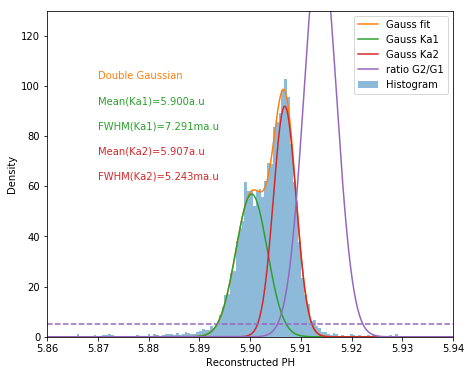

Ka2 PHs in [5.905,5.922] a.u.
PHmin= 5.905385758222846 PHmax= 5.922236772519787


In [25]:
nbinsKas = 200

# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple-pulse rows)
print(min(dataKas_HR.SIGNAL), max(dataKas_HR.SIGNAL))
dataKas_HR = dataKas_HR[(dataKas_HR.SIGNAL>5.80) & (dataKas_HR.SIGNAL<5.95)]
print(min(dataKas_HR.SIGNAL), max(dataKas_HR.SIGNAL))
(PHmin,PHmax) = fit2GaussAndRatio(data=dataKas_HR.SIGNAL, a1=60, a2=120, mean1=5.89, mean2=5.905, sig1=0.005, sig2=0.005, 
                            nbins1=nbinsKas, xlab="Reconstructed PH")
print("PHmin=",PHmin, "PHmax=", PHmax)

#### 2.2.3 Select PH_ID of (non)Ka2 pulses

In [26]:

#select PH_IDs for Ka2 (in [PHmin,PHmax] interval)
dataKa2 = dataKas_HR[(dataKas_HR.SIGNAL >= PHmin) & (dataKas.SIGNAL <= PHmax)]

PH_ID_Ka2 = dataKa2.PH_ID.to_list()
PH_ID_Ka2_single = set(PH_ID_Ka2).intersection(dataKas_single_PH_ID) # good Ka2 pulses

#select PH_IDs to exclude Ka2 in single-pulse records
PH_ID_noKa2 = list(set(dataKas.PH_ID.to_list()).difference(PH_ID_Ka2_single))
print("Number of non-Ka2-single pulses:", len(PH_ID_noKa2))

Number of non-Ka2-single pulses: 7496


/home/ceballos/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


#### 2.2.4 Extract Ka2 pulses to build a new library

In [27]:
run = False
if run:
    tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
    nphs = len(PH_ID_noKa2)
    # first iteration
    expr = "'PH_ID != " + str(PH_ID_noKa2[0]) + "'"
    comm = ("fselect infile=" + fileph_Kas + "+8 outfile=" + fileph_Ka2 + " clobber=yes expr=" + expr)
    try:
        print("Selecting Ka2 pulses")
        print(comm)
        args = shlex.split(comm)
        #check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting Ka2 pulses with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    # other non-selections follow
    iph = 1
    while iph < nphs:
        expr = "'"
        iiph = 1
        while (iiph < 20 and iph < nphs-1):
            expr = expr + "PH_ID != " + str(PH_ID_noKa2[iph]) + " && "
            iiph += 1
            iph  += 1

        expr = expr + "PH_ID != " + str(PH_ID_noKa2[iph]) + "'"
        iph += 1
        comm = ("fselect infile=" + fileph_Ka2 + "+8 outfile=" + tmpFile + " clobber=yes expr=" + expr)
        try:
            print("Selecting Ka2 pulses")
            print("iph=" + str(iph) + "/" + str(nphs))
            print(comm)
            args = shlex.split(comm)
            #check_call(args, stderr=STDOUT)
        except RuntimeError:
            print("Error Selecting Ka2 pulses with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise

        shutil.copy(tmpFile, fileph_Ka2)
        os.remove(tmpFile)
        
    print("Finshed selection of Ka2 events")
    #raise SystemExit("Stop after selection of Ka2")

### 2.3 Build the new library of Ka2 pulses

In [28]:
run = False
if run:
    tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
    comm = ("tesreconstruction Recordfile=" + fileph_Ka2 + " TesEventFile=" + tmpFile + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKa2 + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=0 OFLib=yes FilterDomain=F " + 
            " detectionMode=STC detectSP=1 FilterMethod=" + F0orB0 + " clobber=yes EventListSize=1000" + 
            " EnergyMethod=" + method + " LagsOrNot=1 tstartPulse1=0 tstartPulse2=0 OFNoise=NSD " + 
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(Ka2eV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " NoiseFile=" + noisefile +
            " monoenergy=" + str(Ka2eV) + " preBuffer=" + str(preBuffer))
    try:
        print("Building initial library (Kas)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Building initial library (Kas) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    os.remove(tmpFile)

## 3. Reconstruct all pulses with new Ka2 library

In [29]:
run = False
if run:
    comm = ("tesreconstruction Recordfile=" + fileph + " TesEventFile=" + evt_libKa2 + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKa2 + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
            " detectSP=1 FilterMethod=F0 clobber=yes EnergyMethod=" + method + " LagsOrNot=1 " +
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(Ka2eV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
    try:
        print("Reconstructing real data w/ library (Ka2)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Reconstructing real data w/ initial library (Ka2) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

    # Select only HR events
    comm = ("fselect  infile=" + evt_libKa2 + " outfile=" + evt_libKa2_HR + " expr='GRADE1 == " + str(plen) + 
           " && GRADE2 == " + str(plen) + "'")
    try:
        print("Selecting HR evts")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting HR Kas & Kb evts with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

## 4. Fit Voigt profiles (and calibrate data)

### 4.1 Read HR pulses

In [39]:
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2, PHI, LAGS, BSLN'" 
comm = ("fdump wrap=yes infile=" + evt_libKa2_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes pagewidth=256")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
data_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of initial (all energies) HR pulses:", len(data_HR)) 
#print(data_HR)


FDUMPing evt file
Number of initial (all energies) HR pulses: 13758


### 4.2 Plot initial data

Missing 1 records due to unusual baseline(< 100000.0 )
Missing 1 records due to unusual baseline(< 100000.0 )
100701


Text(0,0.5,'number of pulses')

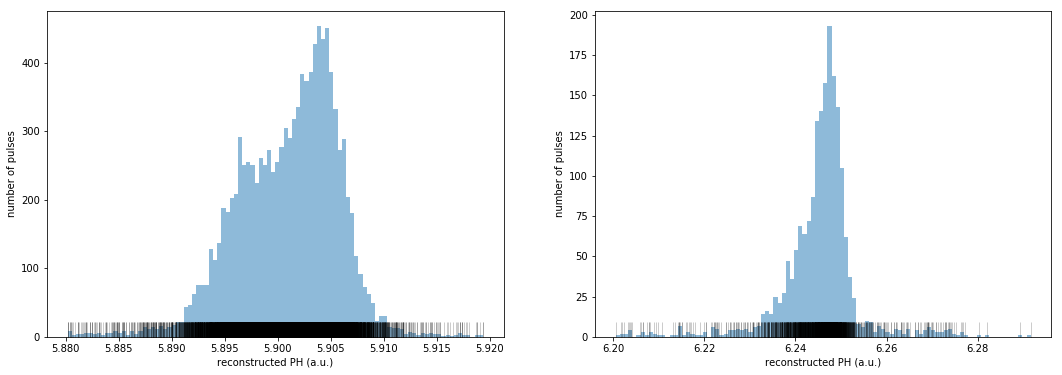

In [117]:
nbinsKas = 100
nbinsKb = 100
minBSLN = 1e5

# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple rows)
dataKas_HR = data_HR[(data_HR.SIGNAL>5.88) & (data_HR.SIGNAL<5.92)]
len1 = len(dataKas_HR)
dataKas_HR = dataKas_HR[dataKas_HR.BSLN>minBSLN]
len2 = len(dataKas_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")

# select data in Kb range
dataKb_HR = data_HR[(data_HR.SIGNAL>6.20) & (data_HR.SIGNAL<6.30)]
len1 = len(dataKb_HR)
dataKb_HR = dataKb_HR[dataKb_HR.BSLN>minBSLN]
len2 = len(dataKb_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")
print(min(dataKb_HR.BSLN))

# INITIAL plot of data
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax1, ax2 = axarr
values, bins, patches = ax1.hist(dataKas_HR.SIGNAL, bins=nbinsKas, alpha=0.5)
rug(ax1, dataKas_HR.SIGNAL)
ax1.set_xlabel('reconstructed PH (a.u.)')
ax1.set_ylabel('number of pulses')

values, bins, patches = ax2.hist(dataKb_HR.SIGNAL, bins=nbinsKb, alpha=0.5)
rug(ax2, dataKb_HR.SIGNAL)
ax2.set_xlabel('reconstructed PH (a.u.)')
ax2.set_ylabel('number of pulses')




### 4.3 Rescale the data prior to the fitting procedure

In [118]:
# factors "by eye"
global_mean_Kas = 5.90
global_mean_Kb = 6.25
global_scale = 100
dataKas_HR_nor = (dataKas_HR.SIGNAL - global_mean_Kas) * global_scale
dataKb_HR_nor = (dataKb_HR.SIGNAL - global_mean_Kb) * global_scale

Text(0,0.5,'number of pulses')

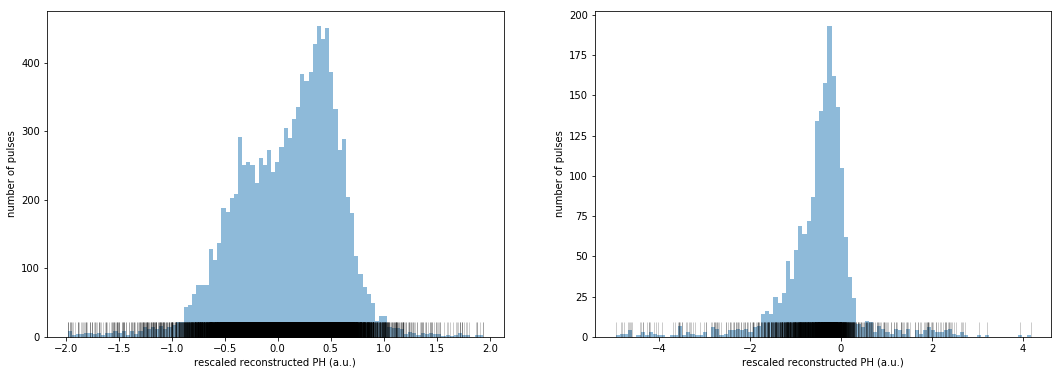

In [119]:
# INITIAL plot of data
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax1, ax2 = axarr
values, bins, patches = ax1.hist(dataKas_HR_nor, bins=nbinsKas, alpha=0.5)
rug(ax1, dataKas_HR_nor)
ax1.set_xlabel('rescaled reconstructed PH (a.u.)')
ax1.set_ylabel('number of pulses')

values, bins, patches = ax2.hist(dataKb_HR_nor, bins=nbinsKb, alpha=0.5)
rug(ax2, dataKb_HR_nor)
ax2.set_xlabel('rescaled reconstructed PH (a.u.)')
ax2.set_ylabel('number of pulses')

### 4.4 Fit of two Gaussians

#### Initial solution guess

In [125]:
# Kas
params = Parameters()
params.add('w1', value=1/3, min=0.001, max = 0.99)
params.add('w2', expr='1-w1', min=0.001, max = 0.99)
params.add('mu1', value=-0.5, min=-1.0, max = 0)
params.add('mu2', value=0.5, min=0., max = 1.)
params.add('sigma1', value=0.3, min = 0.01, max = 0.6)
params.add('sigma2', value=0.3, min = 0.01, max = 1)
params.pretty_print()

Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
mu1         -0.5       -1        0     None     True     None     None
mu2          0.5        0        1     None     True     None     None
sigma1       0.3     0.01      0.6     None     True     None     None
sigma2       0.3     0.01        1     None     True     None     None
w1        0.3333    0.001     0.99     None     True     None     None
w2        0.6667    0.001     0.99     None    False     1-w1     None


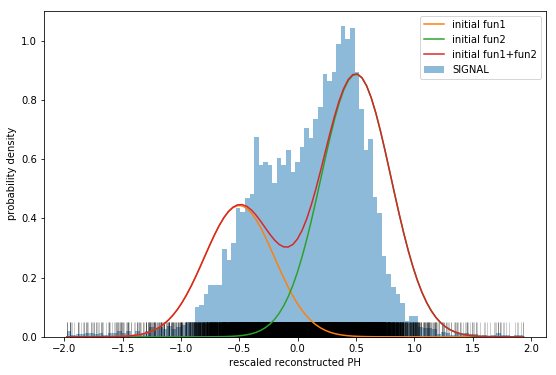

In [126]:
plot_hist_2gauss(data=dataKas_HR_nor, params=params, xlabel='rescaled reconstructed PH', labelprefix='initial')

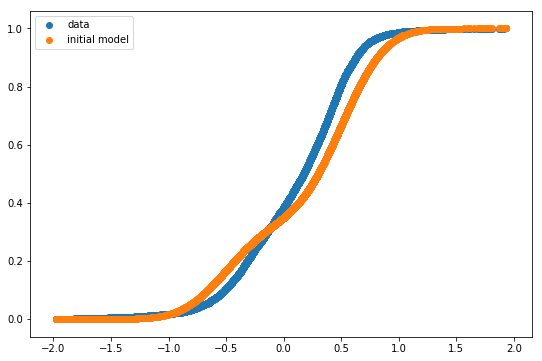

In [127]:
# plot CDF for data and initial model
xecdf_data, yecdf_data, ycdf_model = \
    ecdf_2gauss(data=dataKas_HR_nor, params=params, modellabel='initial model', plot=True)

In [128]:
# fitting with lmfit.minimize
out = minimize(residual_2gauss, params, args=(xecdf_data, yecdf_data))
out.params.pretty_print()

Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
mu1      -0.2304       -1        0 0.001234     True     None     None
mu2       0.4257        0        1 0.0004748     True     None     None
sigma1    0.3458     0.01      0.6 0.0007855     True     None     None
sigma2    0.2288     0.01        1 0.0003051     True     None     None
w1        0.4923    0.001     0.99 0.001353     True     None     None
w2        0.5077    0.001     0.99 0.001353    False     1-w1     None


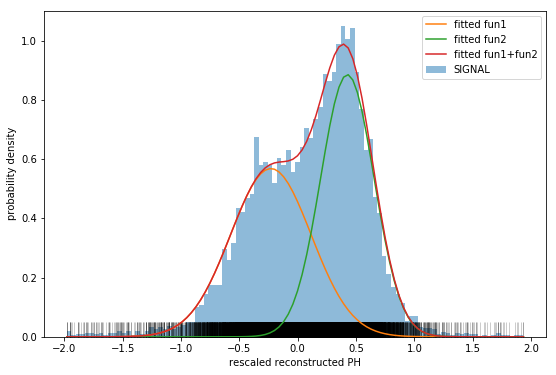

In [129]:
plot_hist_2gauss(data=dataKas_HR_nor, params=out.params, xlabel='rescaled reconstructed PH', labelprefix='fitted')

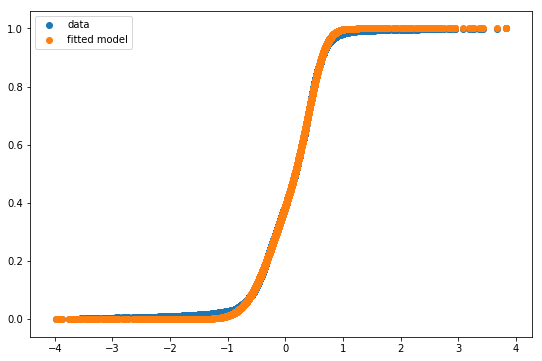

In [116]:
xecdf_data, yecdf_data, ycdf_model = \
    ecdf_2gauss(data=dataKas_HR_nor, params=out.params, modellabel='fitted model', plot=True)

### 4.4 Calibrate energies

In [ ]:
eners_HR = inter + slope * data_HR.SIGNAL
# select data in Kas/Kb range (otherwise there is always a smaller pulse comimg from multiple rows)
enerKs_HR = eners_HR[(eners_HR > 5.80) & (eners_HR < 6.6)]

# create histogram
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1, 2, 1)
bin_heights, bin_borders, _ = ax1.hist(enerKs_HR,bins=200, density=True,label="Histogram", alpha=0.5)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
ax1.set_xlabel("Calibrated energies (keV)")
ax1.set_ylabel("Density")


## 5. Get FWHM of Kas lines fitting Voigt profiles

In [ ]:
nbinsKas = 100
nbinsKb = 100
# select data in Kas/Kb range (otherwise there is always a smaller pulse comimg from multiple rows)
enerKas_HR = eners_HR[(eners_HR > 5.85) & (eners_HR < 5.94)]
#enerKas_HR.to_csv(resDir + "/enerKas_HR.hist", header=None, index=False )
enerKb_HR = eners_HR[(eners_HR>6.35) & (eners_HR<6.6)]

fit3Voigt2hist(data1=enerKas_HR, data2=enerKb_HR, a1=30, a2=60, a3=60, x0_1=Ka1keV, x0_2=Ka2keV, x0_3=KbkeV, 
                   fwhm_L1=0.005, fwhm_L2=0.005, fwhm_L3=0.005, fwhm_G1=0.002, fwhm_G2=0.002, 
                   fwhm_G3=0.002, nbins1=nbinsKas, nbins2=nbinsKb)

## 6. Jitter correction

### 6.1 Plot Pulse Height vs PHASE (distance between trigger and parabola fit = PHI + LAGS) & fit polynomial

In [ ]:
# FROM ABOVE:
#dataKas_HR = data_HR[(data_HR.SIGNAL>5.80) & (data_HR.SIGNAL<5.95) & (data_HR.BSLN>50000)]
#dataKb_HR = data_HR[(data_HR.SIGNAL>6.15) & (data_HR.SIGNAL<6.35) & (data_HR.BSLN>50000)]

phaseKas_HR = dataKas_HR.PHI + dataKas_HR.LAGS
phaseKb_HR = dataKb_HR.PHI + dataKb_HR.LAGS
#print(len(phaseKas_HR))

dataKas_HR_jitter = jitterCorr(reconPH=dataKas_HR.SIGNAL, phase=phaseKas_HR)
dataKb_HR_jitter = jitterCorr(reconPH=dataKb_HR.SIGNAL, phase=phaseKb_HR)


### 6.2 Fit gaussians, create new Gain scale and re-calibrate energies

In [ ]:
nbinsKas = 200
nbinsKb = 200

(mean1j, mean2j, mean3j) = fit3gauss2hist(data1=dataKas_HR_jitter, data2=dataKb_HR_jitter, a1=56, a2=110, a3=100, 
                                       mean1=5.895, mean2=5.905, mean3=6.25, sig1=0.005, sig2=0.005, sig3=0.005,
                                       nbins1=nbinsKas, nbins2=nbinsKb, plot=True)

In [ ]:
# create gain scale
recon_lines = (mean1j,mean2j,mean3j)
(slope, inter) = gainScaleFit(xData=recon_lines, yData=lines)

In [ ]:
# recalibrate energies
enerKas_HR_jitter = inter + slope * dataKas_HR_jitter
enerKb_HR_jitter = inter + slope * dataKb_HR_jitter
print(min(enerKas_HR_jitter), max(enerKas_HR_jitter))

### 6.3 Fit histogram of jitter-corrected energies

In [ ]:
nbinsKas = 200
nbinsKb = 200

fit3Voigt2hist(data1=enerKas_HR_jitter, data2=enerKb_HR_jitter, a1=40, a2=70, a3=60,
               x0_1=Ka1keV, x0_2=Ka2keV, x0_3=KbkeV, fwhm_L1=0.005, fwhm_L2=0.005, fwhm_L3=0.005, 
               fwhm_G1=0.0001, fwhm_G2=0.0001, fwhm_G3=0.001, nbins1=nbinsKas, nbins2=nbinsKb)


## 7. baseline drift correction

### 7.1 Plot jiterr_recon PH vs Baseline & Fit polynomial


In [ ]:
baseKas_HR = dataKas_HR.BSLN - 1e5
baseKb_HR = dataKb_HR.BSLN - 1e5
print(min(dataKb_HR.BSLN))

######## Kas ####################
# plot baselines
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(baseKas_HR, dataKas_HR_jitter, marker="o")
# fit polynomial
x_interval_for_fit = np.linspace(min(baseKas_HR), max(baseKas_HR), 10000)
coefs = poly.polyfit(x=baseKas_HR, y=dataKas_HR_jitter, deg=2) 
#print(coefs)
ffit = poly.polyval(x_interval_for_fit, coefs)
ax1.plot(x_interval_for_fit, ffit,'-', color="red")
ax1.set_xlabel("(pre) baseline (a.u.)")
ax1.set_ylabel("Jitter-corr PH Kas (a.u.)")
print("Fit Kas=",'{:0.3f}'.format(coefs[0]) + "+ (" + '{:0.3f}'.format(coefs[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefs[2]) + ")*x²" )
# subtract polynomial (flat baseline effect)
ax2 = fig.add_subplot(2, 2, 2)
dataKas_HR_jitter_bsln = dataKas_HR_jitter - coefs[1]*baseKas_HR - coefs[2]*baseKas_HR**2
ax2.scatter(baseKas_HR, dataKas_HR_jitter_bsln, marker="o")
ax2.set_xlabel("(pre) baseline (a.u.)")
ax2.set_ylabel("BSLN+JITTER Corrected PH Kas (a.u.)")
coefsB = poly.polyfit(x=baseKas_HR, y=dataKas_HR_jitter_bsln, deg=2)
print("Fit Kas (corrected)=",'{:0.3f}'.format(coefsB[0]) + "+ (" + '{:0.3f}'.format(coefsB[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefsB[2]) + ")*x²" )
ffitB = poly.polyval(x_interval_for_fit, coefsB)
ax2.plot(x_interval_for_fit, ffitB,'-', color="white")

######## Kb ####################
# plot baselines
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(baseKb_HR, dataKb_HR_jitter, marker="o")
# fit polynomial
x_interval_for_fit = np.linspace(min(baseKb_HR), max(baseKb_HR), 10000)
coefs = poly.polyfit(x=baseKb_HR, y=dataKb_HR_jitter, deg=2) # recommended instead of np.polyfit + np.poly1d
ffit = poly.polyval(x_interval_for_fit, coefs)
ax3.plot(x_interval_for_fit, ffit,'-', color="red")
ax3.set_xlabel("(pre) baseline (a.u.)")
ax3.set_ylabel("Jitter-corr PH Kas (a.u.)")
print("Fit Kb=",'{:0.3f}'.format(coefs[0]) + "+ (" + '{:0.3f}'.format(coefs[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefs[2]) + ")*x²" )
# subtract polynomial (flat jitter effect)
ax4 = fig.add_subplot(2, 2, 4)
dataKb_HR_jitter_bsln = dataKb_HR_jitter - coefs[1]*baseKb_HR - coefs[2]*baseKb_HR**2
ax4.scatter(baseKb_HR, dataKb_HR_jitter_bsln, marker="o")
ax4.set_xlabel("(pre) baseline (a.u.)")
ax4.set_ylabel("BSLN+JITTER Corrected PH Kas (a.u.)")
coefsB = poly.polyfit(x=baseKb_HR, y=dataKb_HR_jitter_bsln, deg=2)
print("Fit Kb (corrected)=",'{:0.3f}'.format(coefsB[0]) + "+ (" + '{:0.3f}'.format(coefsB[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefsB[2]) + ")*x²" )
ffitB = poly.polyval(x_interval_for_fit, coefsB)
ax4.plot(x_interval_for_fit, ffitB,'-', color="white")

### 7.2 Fit gaussians, create new Gain scale and re-calibrate energies

In [ ]:
nbinsKas = 200
nbinsKb = 200

(mean1bsln, mean2bsln, mean3bsln) = fit3gauss2hist(data1=dataKas_HR_jitter_bsln, data2=dataKb_HR_jitter_bsln, 
                                                   a1=60, a2=120, a3=110, mean1=5.86, mean2=5.87, mean3=6.24,
                                                   sig1=0.005, sig2=0.005, sig3=0.005, nbins1=nbinsKas, nbins2=nbinsKb, plot=True)

In [ ]:
# create gain scale
recon_lines = (mean1bsln,mean2bsln,mean3bsln)
(slope, inter) = gainScaleFit(xData=recon_lines, yData=lines)


In [ ]:
# recalibrate energies
#enerKas_HR_jitter_bsln = coefs[0] + coefs[1] * dataKas_HR_jitter_bsln + coefs[2] * dataKas_HR_jitter_bsln**2
#enerKb_HR_jitter_bsln = coefs[0] + coefs[1] * dataKb_HR_jitter_bsln + coefs[2] * dataKb_HR_jitter_bsln**2
enerKas_HR_jitter_bsln = inter + slope * dataKas_HR_jitter_bsln
enerKb_HR_jitter_bsln = inter + slope * dataKb_HR_jitter_bsln

In [ ]:
nbinsKas = 200
nbinsKb = 200
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1, 2, 1)

# create histogram
bin_heights, bin_borders, _ = ax1.hist(enerKas_HR_jitter_bsln,bins=nbinsKas, density=True,label="Histogram", alpha=0.5)
ax1.set_xlim(5.85, 5.94)
ax1.set_xlabel("Energy (keV)")
ax1.set_ylabel("Density")
ax1.axvline(Ka1keV,linestyle='--', color='gray')
ax1.axvline(Ka2keV,linestyle='--', color='gray')


### 7.3 Fit histogram of baseline-jitter-corrected energies

In [ ]:
nbinsKas = 200
nbinsKb = 200

fit3Voigt2hist(data1=enerKas_HR_jitter_bsln, data2=enerKb_HR_jitter_bsln, a1=50, a2=85, a3=90,
               x0_1=Ka1keV, x0_2=Ka2keV, x0_3=KbkeV, fwhm_L1=0.005, fwhm_L2=0.005, fwhm_L3=0.005, 
               fwhm_G1=0.0001, fwhm_G2=0.0001, fwhm_G3=0.001, nbins1=nbinsKas, nbins2=nbinsKb)


## 8. Absolute value

### 8.1 Reconstruct pulses with Ka2 library and absolute values

In [ ]:
run = False
if run:
    comm = ("tesreconstruction Recordfile=" + fileph + " TesEventFile=" + evt_libKa2_abs + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKa2 + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
            " detectSP=1 FilterMethod=F0 clobber=yes EnergyMethod=" + method + " LagsOrNot=1 " +
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(Ka2eV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
    try:
        print("Reconstructing real data w/ library (Ka2)")
        print(comm)
        args = shlex.split(comm)
        #check_call(args, stderr=STDOUT)
    except:
        print("Error Reconstructing real data w/ initial library (Ka2) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

    # Select only HR events
    comm = ("fselect  infile=" + evt_libKa2_abs + " outfile=" + evt_libKa2_abs_HR + " expr='GRADE1 == " + str(plen) + 
           " && GRADE2 == " + str(plen) + "'")
    try:
        print("Selecting HR evts")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting HR Kas & Kb evts with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 8.2 Read HR pulses

In [ ]:
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2, PHI, LAGS, BSLN'" 
comm = ("fdump wrap=yes infile=" + evt_libKa2_abs_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes pagewidth=256")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
dataAbs_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of initial (all energies) HR pulses:", len(dataAbs_HR)) 
#print(dataAbs_HR)

### 8.3 Fit 2 gaussians to Kas and 1 gaussian to Kb

In [ ]:
nbinsKas = 200
nbinsKb = 200
minBSLN = 1e5
# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple rows)
dataKasAbs_HR = dataAbs_HR[(dataAbs_HR.SIGNAL>5.80) & (dataAbs_HR.SIGNAL<5.95)]
len1 = len(dataKasAbs_HR)
dataKasAbs_HR = dataKasAbs_HR[dataKasAbs_HR.BSLN>minBSLN]
len2 = len(dataKasAbs_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")

# select data in Kb range
dataKbAbs_HR = dataAbs_HR[(dataAbs_HR.SIGNAL>6.15) & (dataAbs_HR.SIGNAL<6.35)]
len1 = len(dataKbAbs_HR)
dataKbAbs_HR = dataKbAbs_HR[dataKbAbs_HR.BSLN>minBSLN]
len2 = len(dataKbAbs_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")
print("Min baseline=",min(dataKbAbs_HR.BSLN))

# Fit Gaussians and plot results
(mean1abs, mean2abs,mean3abs) = fit3gauss2hist(data1=dataKasAbs_HR.SIGNAL, data2=dataKbAbs_HR.SIGNAL, 
                                               a1=56, a2=110, a3=100, mean1=5.89, mean2=5.90, mean3=6.25, 
                                               sig1=0.005, sig2=0.005, sig3=0.005, 
                                               nbins1=nbinsKas, nbins2=nbinsKb, plot=True)


### 8.4 Create gain scale

In [ ]:
lines = (Ka1keV, Ka2keV, KbkeV)
recon_lines = (mean1abs,mean2abs,mean3abs)

In [ ]:
# gain scale
(slopeAbs, interAbs) = gainScaleFit(xData=recon_lines, yData=lines)

### 8.5 Calibrate energies

In [ ]:
enersAbs_HR = interAbs + slopeAbs * dataAbs_HR.SIGNAL
# select data in Kas/Kb range (otherwise there is always a smaller pulse comimg from multiple rows)
enerKsAbs_HR = enersAbs_HR[(enersAbs_HR > 5.80) & (enersAbs_HR < 6.6)]

# create histogram
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1, 2, 1)
bin_heights, bin_borders, _ = ax1.hist(enerKsAbs_HR,bins=200, density=True,label="Histogram", alpha=0.5)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
ax1.set_xlabel("Calibrated energies (keV) - abs. value scalar prod.")
ax1.set_ylabel("Density")


### 8.6. Get FWHM of Kas lines fitting Voigt profiles

In [ ]:
nbinsKas = 100
nbinsKb = 100
enerKasAbs_HR = enersAbs_HR[(enersAbs_HR > 5.85) & (enersAbs_HR < 5.94)]
#enerKasAbs_HR.to_csv(resDir + "/enerKasAbs_HR.hist", header=None, index=False )
enerKbAbs_HR = enersAbs_HR[(enersAbs_HR>6.35) & (enersAbs_HR<6.6)]

fit3Voigt2hist(data1=enerKasAbs_HR, data2=enerKbAbs_HR, a1=50, a2=70, a3=50,
               x0_1=Ka1keV, x0_2=Ka2keV, x0_3=KbkeV, fwhm_L1=0.005, fwhm_L2=0.005, fwhm_L3=0.005, 
               fwhm_G1=0.0001, fwhm_G2=0.0001, fwhm_G3=0.001, nbins1=nbinsKas, nbins2=nbinsKb)


### 8.7. Jitter correction

#### 8.7.1 Plot energy vs PHASE (distance between trigger and parabola fit = PHI + LAGS) & fit polynomial

In [ ]:
# FROM ABOVE:
#dataKasAbs_HR 
#dataKbAbs_HR 

phaseKasAbs_HR = dataKasAbs_HR.PHI + dataKasAbs_HR.LAGS
phaseKbAbs_HR = dataKbAbs_HR.PHI + dataKbAbs_HR.LAGS
#print(len(phaseKas_HR))

dataKasAbs_HR_jitter = jitterCorr(reconPH=dataKasAbs_HR.SIGNAL, phase=phaseKasAbs_HR)
dataKbAbs_HR_jitter = jitterCorr(reconPH=dataKbAbs_HR.SIGNAL, phase=phaseKbAbs_HR)